# Webtoon negative reviews analysis 

In this mini project, I will leverage machine learning and text analytics techniques to analyze and explain the main reason that caused the number of negative reviews to peak in July 2020. 

## 1. Load Modules

In [1]:
# scraper
from app_store_scraper import AppStore

# core module
import pandas as pd
import numpy as np
import re
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import ticker
import seaborn as sns
from fuzzywuzzy import fuzz

# nlp module
import nltk
import spacy
from spacy.matcher import Matcher
nlp = spacy.load('en_core_web_md')
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words
from sumy.summarizers.lsa import LsaSummarizer
from gensim.summarization import summarize
from wordcloud import WordCloud

# ML module
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.pairwise import cosine_similarity


import text_normalizer_R as tn # self-created module for text normalization

## 2. Define Helper Functions 

In [266]:
# Helper function 
def normalize_document(doc):
    stop_words = nltk.corpus.stopwords.words('english')
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = nltk.word_tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # get the lemmatized tokens
    filtered_tokens = [tn.lemmatize_text_wnl(token) for token in tokens]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

# Plot the Wordcloud graph
def wordcloud_clusters(model, vectors, features, no_top_words=40):
    for cluster in np.unique(model.labels_):
        size = {}
        words = vectors[model.labels_ == cluster].sum(axis=0).A[0]
        largest = words.argsort()[::-1] # invert sort order
        for i in range(0, no_top_words):
            size[features[largest[i]]] = abs(words[largest[i]])
        wc = WordCloud(background_color="white", max_words=100, width=960, height=540)
        wc.generate_from_frequencies(size)
        plt.figure(figsize=(12,12))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")

# Set the uniform plotting style
def plot_style_setting(figsize=[6, 4]):
    plt.style.use('seaborn-whitegrid')
    plt.rcParams['figure.dpi'] = 100
    plt.rcParams['figure.figsize'] = figsize
    plt.rcParams['axes.labelpad'] = 10
    plt.rcParams['axes.grid.axis'] = 'y'
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.right'] = False
#     plt.rcParams['font.sans-serif'] = "monospace"
    plt.rcParams['font.family'] = "monospace"
    params = {i:'#595959' for i in ["axes.titlecolor", "ytick.color", "xtick.color","axes.labelcolor","text.color"]}
    plt.rcParams.update(params)


# Data preprocessing before clustering
def preprocess_responses(reviews):
    # Stop words
    stop_words = nltk.corpus.stopwords.words('english')

    # Preprocess the data for clustering 
    normalize_corpus = np.vectorize(normalize_document)
    norm_corpus = normalize_corpus(list(reviews))
    len(norm_corpus)

    # Create embedding
    ## 1
    cv = CountVectorizer(ngram_range=(1, 3), min_df=3, max_df=0.8, stop_words=stop_words)
    cv_matrix = cv.fit_transform(norm_corpus)
    print()
    print(f'Shape of Count Vec matrix: {cv_matrix.shape}')

    ## 2
    tfidfv = TfidfVectorizer(ngram_range=(1, 3), stop_words=stop_words)
    tfidfv_matrix = tfidfv.fit_transform(norm_corpus)
    print(f'Shape of tfidf matrix: {tfidfv_matrix.shape}')

    return cv, tfidfv, cv_matrix, tfidfv_matrix

# Kmeans clustering 
def clustering(df, vectorizer, matrix, create_dict=False, verbose=True, n_clusters=None):
    # Clustering
    n_clusters = n_clusters
    km = KMeans(n_clusters=n_clusters, max_iter=10000, n_init=50, random_state=42).fit(matrix)
    '''
    KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=10000,
        n_clusters=NUM_CLUSTERS, n_init=50, n_jobs=-1, precompute_distances="auto",
        random_state=42, tol=0.0001, verbose=0)
    '''

    # Create a new columns with cluster labels
    df['kmeans_cluster'] = km.labels_

    # View distribution of response across the clusters
    Counter(km.labels_)

    # Result Analysis
    response_clusters = df[['review', 'kmeans_cluster', 'title']]
    response_clusters = response_clusters.copy(deep=True)

    feature_names = vectorizer.get_feature_names()
    topn_features = 30
    ordered_centroids = km.cluster_centers_.argsort()[:, ::-1]

    # Get key features for each cluster
    # Get important responses belonging to each cluster
    if create_dict:
        reviews_low_dict = defaultdict(dict)
    for cluster_num in range(n_clusters):
        key_features = [feature_names[index]
                            for index in ordered_centroids[cluster_num, :topn_features]]
        title = response_clusters[response_clusters['kmeans_cluster'] == cluster_num]['title'].values.tolist()
        title_topn = response_clusters[response_clusters['kmeans_cluster'] == cluster_num]['title'][:20].values.tolist()
        response = response_clusters[response_clusters['kmeans_cluster'] == cluster_num]['review'].values.tolist()
        response_top5 = response_clusters[response_clusters['kmeans_cluster'] == cluster_num]['review'][:5].values.tolist()
        num_response = len(response_clusters[response_clusters['kmeans_cluster'] == cluster_num]['review'])
        if create_dict:
            summary = summarize('. '.join(response_clusters[response_clusters['kmeans_cluster'] == cluster_num]['review']), ratio=0.05, split=False)

        if verbose:
            print('CLUSTER #'+str(cluster_num+1))
            print(f'Number of Responses:\n{num_response}\n')
            print(f'Key Features:\n{key_features}\n')
            print(f'Response：\n{response_top5}')
            print('-'*80)
            if create_dict:
                reviews_low_dict[cluster_num+1] = {'Number of Responses': num_response, 
                                                   'Key Features': key_features, 
                                                   'Summary': summary, 
                                                   'Titles': title,  
                                                   'Responses':response}
    if verbose:
        # Plot the word cloud 
        wordcloud_clusters(km, vectors=matrix, features=feature_names, no_top_words=30)
    if create_dict:
        return reviews_low_dict
    else:
        return 

# Funzzy match 
def fuzzy_match(word_in_search, text_to_search, thres=70):
    match_tuple = []
    # get match
    for t in range(len(text_to_search)):
        ratio = fuzz.ratio(text_to_search[t].lower(), word_in_search.lower())
        if ratio >= thres:
            match_tuple.append(text_to_search[t])
    # sort
    # match_tuple = sorted(match_tuple, key=lambda x: x[1])[::-1]
    return match_tuple

# TFIDF Summarization
def get_tfidf_summary(responses, num_summary_response=2):
    response_summary = []
    normalize_corpus = np.vectorize(normalize_document)
    norm_corpus = normalize_corpus(list(responses))
    
    # sentences = tokenize.sent_tokenize(text)
    tfidfVectorizer = TfidfVectorizer()
    words_tfidf = tfidfVectorizer.fit_transform(norm_corpus)
    response_sum = words_tfidf.sum(axis=1)
    important_responses = np.argsort(response_sum, axis=0)[::-1]
    for i in range(0, len(norm_corpus)):
        if i in important_responses[:num_summary_response]:
            response_summary.append(responses[i])
    return response_summary


# LSA Summarization
def get_lsa_summary(responses, num_summary_response=2):
    response_summary = []
    LANGUAGE = "english"
    stemmer = Stemmer(LANGUAGE)
    parser = PlaintextParser.from_string('. '.join([r for r in responses]), Tokenizer(LANGUAGE))
    summarizer = LsaSummarizer(stemmer)
    summarizer.stop_words = get_stop_words(LANGUAGE)
    for response in summarizer(parser.document, num_summary_response):
        response_summary.append(str(response))
    return response_summary

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 3. Read Data 

I used the following code to scrape reviews from webtoon. To ensure the data's consistency, in this project I would read the data that I downloaded before using the same piece of code.

In [ ]:
# webtoon = AppStore(country="us", app_name="Webtoon")
# webtoon.review(how_many=3000)
# review_df = pd.DataFrame(webtoon.reviews)
# review_df.to_json('webtoon_review_df.json')

In [4]:
review_df = pd.read_json('webtoon_review_df.json')

We can see that the negative reviews account for nearly 20% of the total reviews, which is pretty low when benchmarked with other similar apps on the App store. 

In [220]:
review_df['rating'].value_counts(normalize=True)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


5    0.349333
4    0.278333
3    0.179000
1    0.102333
2    0.091000
Name: rating, dtype: float64

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


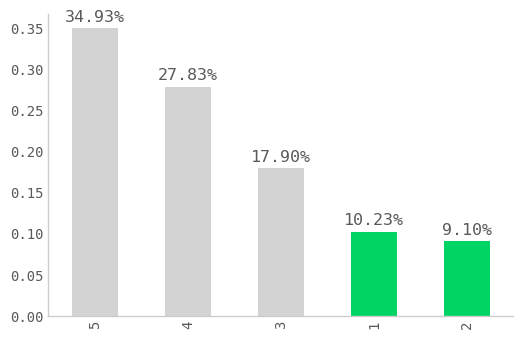

In [268]:
plot_style_setting(figsize=[6, 4])
highlight_color = np.where(review_df['rating'].value_counts(normalize=True).index.isin([1, 2]), '#00d464', 'lightgray')
p = review_df['rating'].value_counts(normalize=True).plot(kind='bar', color=highlight_color)
for bar in p.patches:
    p.annotate(format(bar.get_height(), '.2%'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=12, xytext=(0, 8),
                   textcoords='offset points')
plt.grid(False)

I divided all reviews into two groups, low rating reviews and top rating reviews, with top reviews being those 4 or 5 star reviews and low reviews being those 1 or 2 stars reviews. After the grouping process, I also did a simple text wranggling by expanding the contractions (e.g. I'm -> i am) and replace some special charactrers to machine readable words.

In [7]:
top_rating_df = review_df[review_df.rating == 5].copy()
low_rating_df = review_df[review_df.rating.isin([1, 2])].copy()
low_rating_df = low_rating_df.reset_index(drop=True)

# Normalize the reviews
low_rating_df.loc[:, 'review_clean'] = [tn.expand_contractions(r) for r in low_rating_df['review']]
low_rating_df.loc[:, 'review_clean'] = [r.replace('/', ' or ') for r in low_rating_df['review_clean']]
low_rating_df.loc[:, 'title_clean'] = [tn.expand_contractions(r) for r in low_rating_df['title']]
low_rating_df.loc[:, 'title_clean'] = [r.replace('/', ' or ') for r in low_rating_df['title_clean']]

## 4. Low rating reviews overview 

The original data contains reviews from 2017-2021. In this analysis, I will be focusing on the most recent 2020-2021 data. After filtering, There are 301 negative reviews in our data. 

In [222]:
low_rating_df = low_rating_df[low_rating_df.date >= '2020-01-01']
low_rating_df.shape

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(301, 10)

From the following graph, I noticed that the number of reviews peaked in July 2020, and gradually decline over time, which is a good sign. In this project, I am interested in figuring out what is causing the number of negative reviews to peak during July 2020. 

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


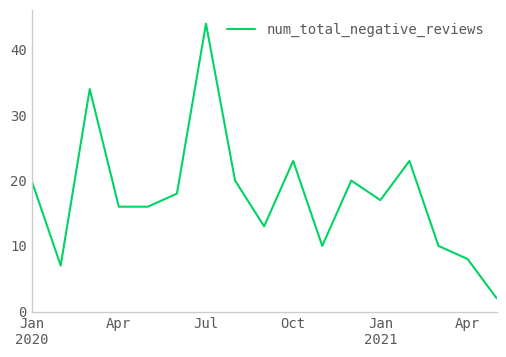

In [269]:
plot_style_setting(figsize=[6, 4])
low_rating_df_cnt = low_rating_df.date.dt.to_period('M').value_counts().to_frame(name='num_total_negative_reviews').sort_index()
low_rating_df_cnt.plot(color='#00d464')
plt.grid(False)

## 5. Perform cluserting to find the potential reasons

I will leverage K-means clustering, an unsupervised machine learning technique, to find out the latent pattern behind the reviews. 

In [12]:
# Preprocess and vectorize the data for the later clustering algo
cv, tfidfv, cv_matrix, tfidfv_matrix = preprocess_responses(low_rating_df['review_clean'])


Shape of Count Vec matrix: (301, 1500)
Shape of tfidf matrix: (301, 31035)


### Perform grid search to find the optimal number of clusters

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


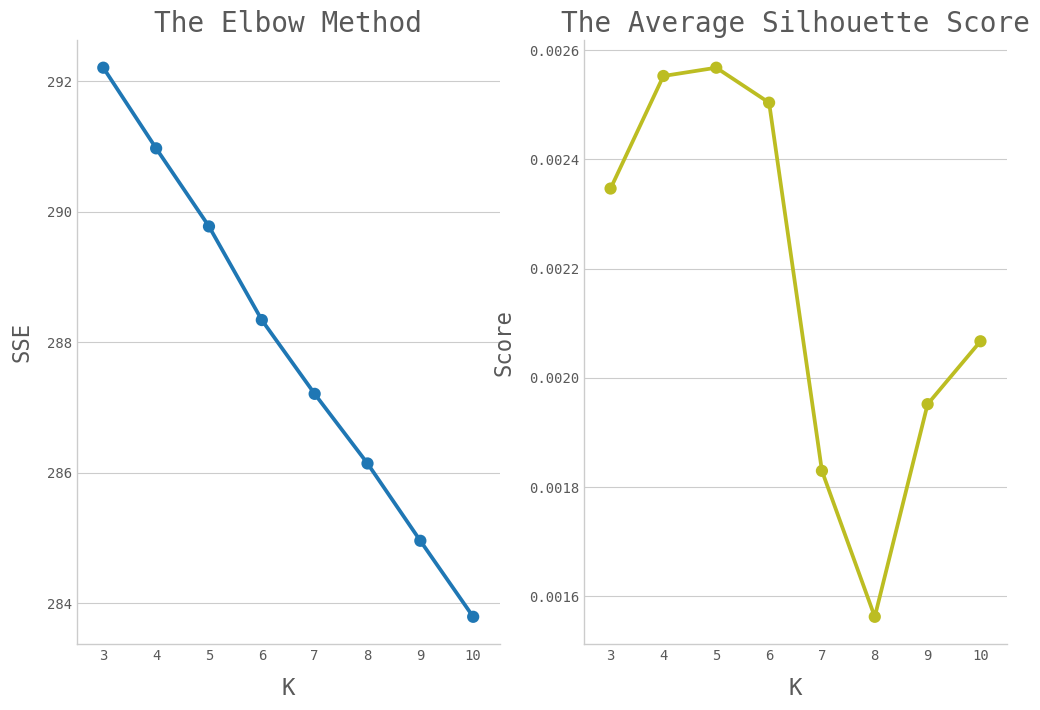

In [225]:
# Create the Scree plot and compute the silhouette_score for optimal K
sse = {}
silhouette_avg = {}
# Fit KMeans and calculate SSE for each k
for k in range(3, 11):
  
    # Initialize KMeans with k clusters and fit KMeans on the normalized dataset
    kmeans = KMeans(n_clusters=k, max_iter=800, n_init=50, random_state=1).fit(tfidfv_matrix)
    preds = kmeans.predict(tfidfv_matrix)
    
    # Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans.inertia_

    # The silhouette_score gives the average value for all the data.
    silhouette_avg[k] = silhouette_score(tfidfv_matrix, preds)

# Use Snake plot to find the optimal number of clusters
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
sns.despine(left=False, bottom=False)
ax1.set_title('The Elbow Method', fontsize = 20)
ax1.set_xlabel('K', fontsize = 16)
ax1.set_ylabel('SSE', fontsize = 16)
sns.pointplot(x=list(sse.keys()), y=list(sse.values()), ax=ax1)

ax2.set_title('The Average Silhouette Score', fontsize = 20)
ax2.set_xlabel('K', fontsize = 16)
ax2.set_ylabel('Score', fontsize = 16)
sns.pointplot(x=list(silhouette_avg.keys()), y=list(silhouette_avg.values()), ax=ax2, color='tab:olive', linestyles="-")
plt.show()

According to the silhouette score, the optimal K is likely to be somewhere near 5. Now let's look at the five clutsers we have and see if we can find anything interesting. Excluding all the technical issues(e.g., account locked, coin loss), which is in the fifth cluster, we see that most people are complaining about the mature content ban policy and daily pass. Let's dig deeper into the daily pass problem as it accounts for the highest number of complaints.  

CLUSTER #1
Number of Responses:
37

Key Features:
['pay', 'read', 'webtoon', 'app', 'coin', 'comic', 'im', 'money', 'story', 'free', 'like', 'dont', 'even', 'got', 'didnt', 'people', 'apple', 'wait', 'apps', 'good', 'make', 'know', 'one', 'password', 'email', 'really', 'chapter', 'back', 'would', 'anything']

Response：
['I love WEBTOON I used to use lezhin and WEBTOON at the same time but I always gave the edge to WEBTOON because it was so much easier to use and I was able to read whatever kind of WEBTOON I wanted anything I wanted. Now I am all for paying paying is important for the app and the people making the content that I love to read. But the coin system is terrible. I hate the coins and they were the reason I stopped using lezhin all together. Now if there was a monthly subscription that I could subscribe to, maybe have different types of subscription for different things. I will literally spend more money a month on WEBTOON than I would on netflix or something. But I refuse to

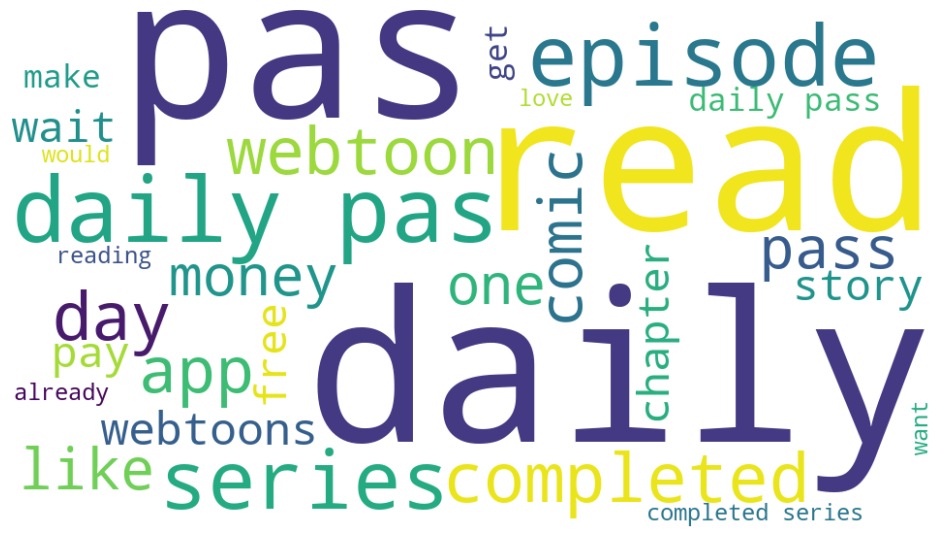

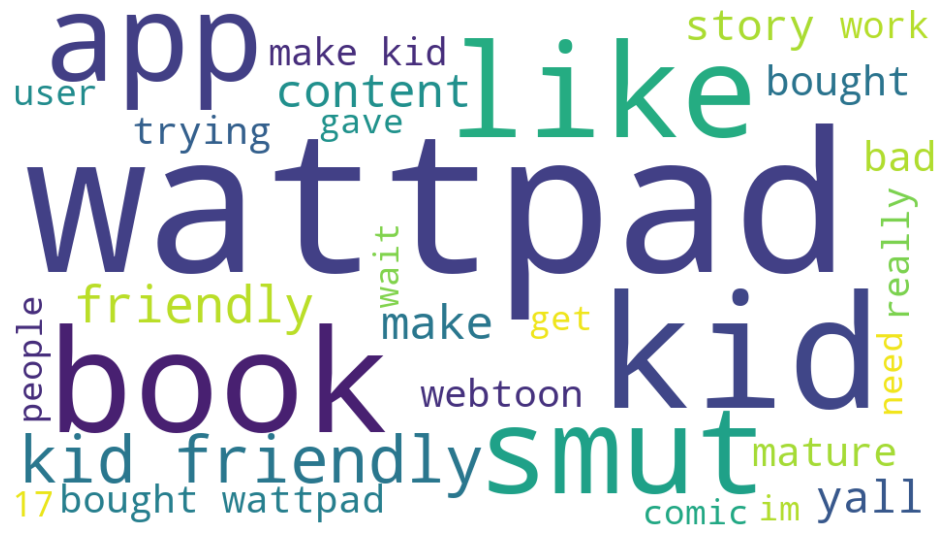

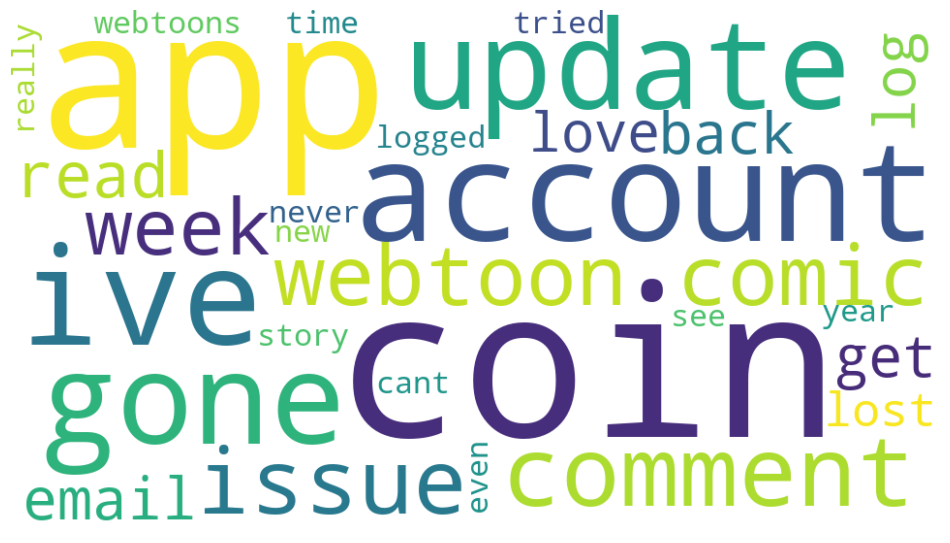

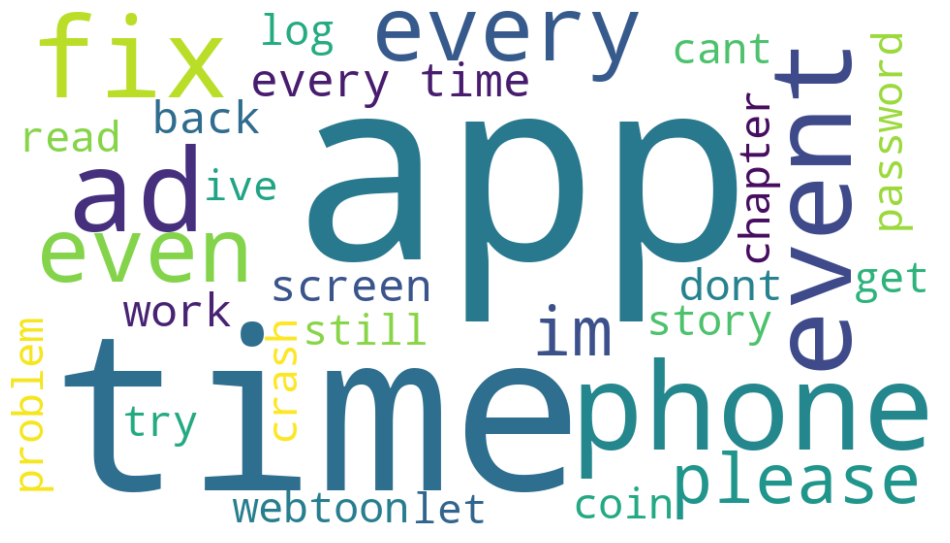

In [14]:
reviews_low_dict = clustering(df=low_rating_df, 
                              vectorizer=tfidfv, 
                              matrix=tfidfv_matrix,
                              create_dict=True, 
                              verbose=True, 
                              n_clusters=5)

From the following result, we see roughly 105 or 35% of total negative reviews related to daily pass.  

In [286]:
idx_select_r = [idx for idx, text in enumerate(low_rating_df['review_clean']) if re.findall(fr'daily pass', text, re.I)]
idx_select_t = [idx for idx, text in enumerate(low_rating_df['title_clean']) if re.findall(fr'daily pass', text, re.I)]
idx_select = list(set(idx_select_t + idx_select_r))
daily_pass_df = low_rating_df.iloc[idx_select].copy().reset_index(drop=True)
daily_pass_df


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


date                                             review  \
0   2020-10-02 19:05:43  I just found out about this today when I was g...   
1   2020-09-20 19:07:55  I used to use webtoon a lot, and I loved it! T...   
2   2020-08-26 20:20:23  I am totally in love and addicted to this app ...   
3   2020-07-12 06:39:19  I’ve had webtoon for a very long time and I’ve...   
4   2020-09-20 21:31:23  Webtoons started off great. The main hurdle to...   
..                  ...                                                ...   
100 2020-07-13 23:07:03  The daily passes are a terrible idea. I never ...   
101 2020-06-08 17:36:33  You use to be able to read old stories for fre...   
102 2020-01-28 01:21:18  This used to be my favorite app for comic read...   
103 2020-05-31 02:57:11  Okay so I used to love this app. I recently re...   
104 2020-07-30 18:04:38  I love reading webtoons and this was my favori...   

           userName                                       title  isEdited  \
0           08Lonso          You’re making people hate your app     False   
1           BikeMac      Completed series are way too expensive     False   
2    strawberri cow                                        BYE-     False   
3     lulu ana 1221                Love WEBTOON HATE daily pass     False   
4    analytics U.S.  Passing off operational costs to consumers     False   
..              ...                                         ...       ...   
100      CareRose17            Daily Passes are ruining webtoon     False   
101   Xianei(^_−)−☆                              I would rate 5     False   
102   Wwertyiuopasd                                         >:(     False   
103        mariii3_                                Daily Pass?!     False   
104       maejojojo                              Daily pass NO.     False   

     rating developerResponse  \
0         2              None   
1         2              None   
2         1              None   
3         2              None   
4         2              None   
..      ...               ...   
100       2              None   
101       1              None   
102       2              None   
103       2              None   
104       1              None   

                                          review_clean  \
0    I just found out about this today when I was g...   
1    I used to use webtoon a lot, and I loved it! T...   
2    I am totally in love and addicted to this app ...   
3    I’ve had webtoon for a very long time and I’ve...   
4    Webtoons started off great. The main hurdle to...   
..                                                 ...   
100  The daily passes are a terrible idea. I never ...   
101  You use to be able to read old stories for fre...   
102  This used to be my favorite app for comic read...   
103  Okay so I used to love this app. I recently re...   
104  I love reading webtoons and this was my favori...   

                                    title_clean  kmeans_cluster  
0            You’re making people hate your app               1  
1        Completed series are way too expensive               1  
2                                          BYE-               1  
3                  Love WEBTOON HATE daily pass               1  
4    Passing off operational costs to consumers               1  
..                                          ...             ...  
100            Daily Passes are ruining webtoon               1  
101                              I would rate 5               1  
102                                         >:(               1  
103                                Daily Pass?!               1  
104                              Daily pass NO.               1  

[105 rows x 10 columns]

If we plot out these daily pass related negative reviews, we can see from the line chart that it bears a similiar pattern as that of total negative views and is probably the main reason why there exists the peak in the number of negative reviews in July.

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


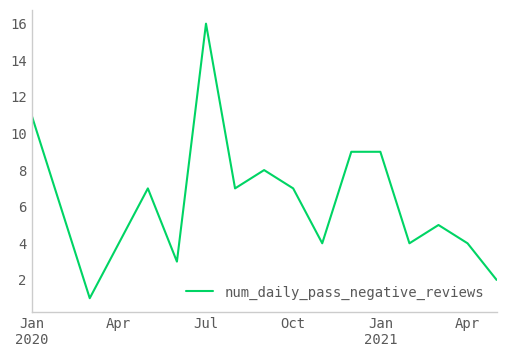

In [271]:
plot_style_setting(figsize=[6, 4])
daily_pass_df_cnt = daily_pass_df.date.dt.to_period('M').value_counts().to_frame(name='num_daily_pass_negative_reviews').sort_index()
daily_pass_df_cnt.plot(color='#00d464')
plt.grid(False)

## 6. A deep dive into daily pass problem

Now we know that the daily pass problem is likely to be key components of the negative reviews is July. I am then curious about why people dislike this paywall so much. My initial attempt is to perform clustering again and see if we spot any interesting signs.

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

Shape of Count Vec matrix: (105, 670)
Shape of tfidf matrix: (105, 12807)
CLUSTER #1
Number of Responses:
6

Key Features:
['story', 'stupid daily', 'half', 'reader', 'one', 'comment', 'read', 'daily', 'stupid', 'time', 'reader webtoon', 'pas', 'stupid daily pas', 'webtoon', 'daily pas', 'much', 'half time', 'need', 'get', 'reading webtoon', 'work', 'im', 'pas feature', 'daily pas feature', 'comic', 'coin', 'favorite', 'im even', 'amount', 'artist']

Response：
['I love this app. always have. now i rarely write reviews for anything but I feel as if this has just been taken too far. The stories are amazing and I love how they support u

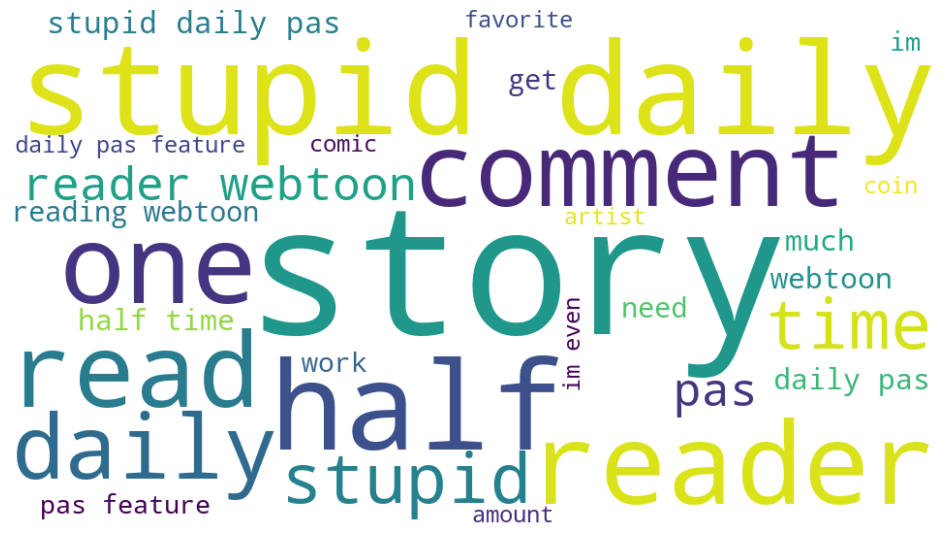

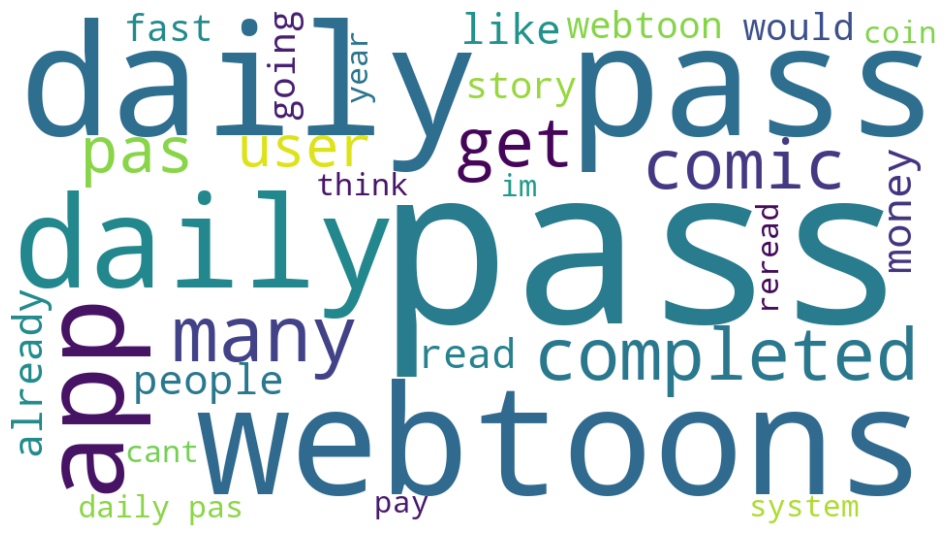

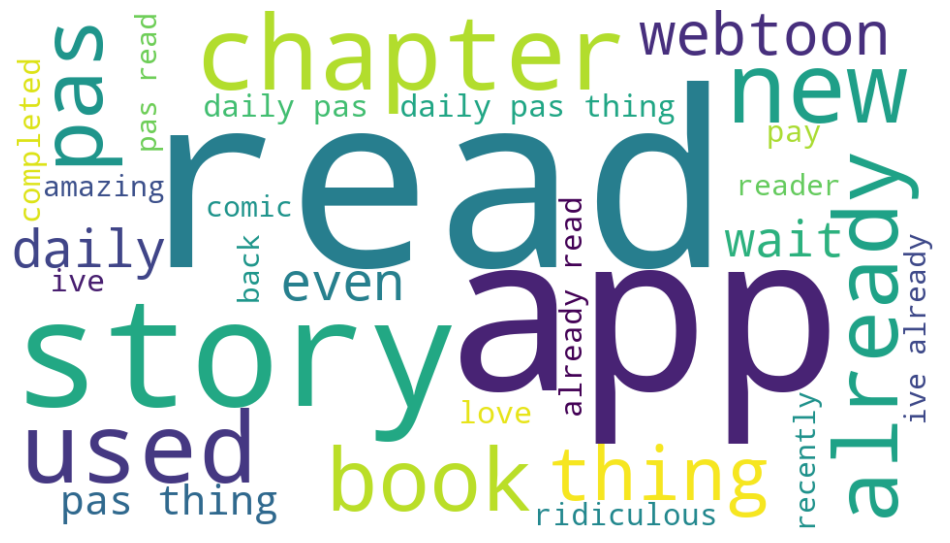

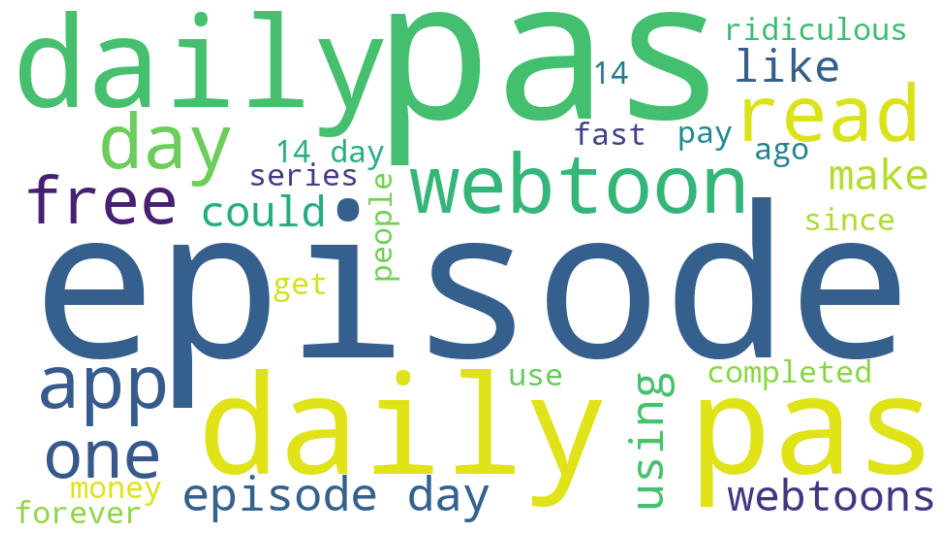

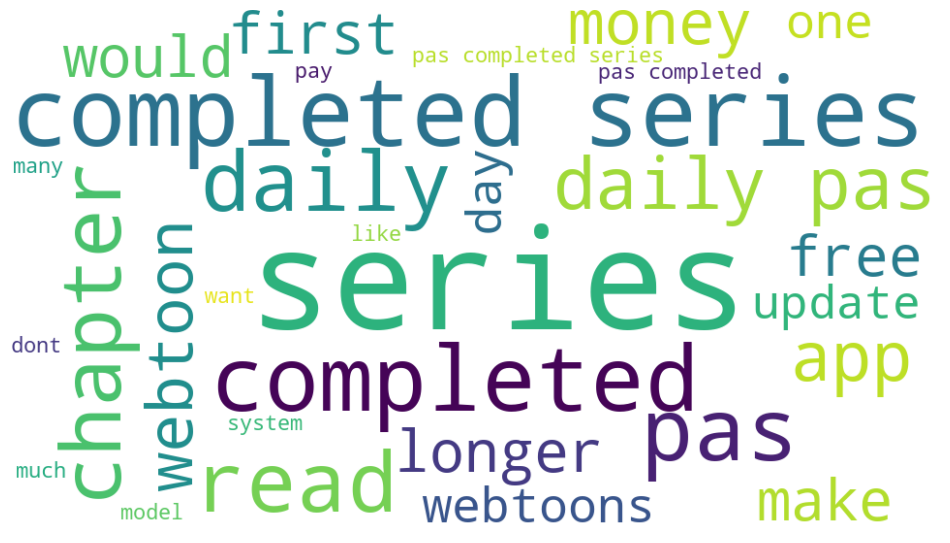

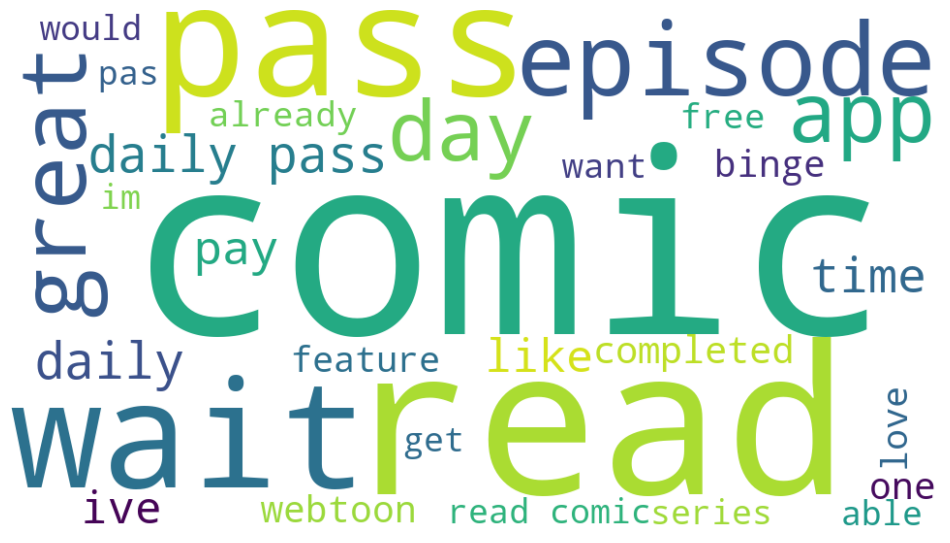

In [273]:
dp_cv, dp_tfidfv, dp_cv_matrix, dp_tfidfv_matrix = preprocess_responses(daily_pass_df['review_clean'])
clustering(daily_pass_df, dp_tfidfv, dp_tfidfv_matrix, n_clusters=6)

Unfortunately, at first glance, I didn't observe any exciting patterns. I then switched gear to use different feature schemes like pairwise review similarity, to group similar reviews in clusters and apply the summarization techniques to extract the most critical insights from each cluster. 

Next, I would like to quickly walk you through the three methods that I use and will focus more on the mechanism behind the model instead of the math.

1. **TF-IDF summarization**: The first approach is to identify essential sentences based on an aggregate of the TF-IDF values of the words in a review. What TF-IDF does is basically reduce weights of frequent words and at the same time increase the weights of uncommon words.

2. **LSA summarization**: In the LSA(Latent Semantic Analysis) algorithm, I first represent the entire collection of reviews in the form of a sentence-term matrix. The objective of this method is to reduce all the words to a few topics by creating a modified representation of the sentence-term matrix. To create the modified representation, people usually apply the method of nonnegative matrix factorization that expresses this matrix as the product of two new decomposed matrices that have fewer rows/columns.

3. **TextRank summarization**: TextRank is one of the most popular examples of an indicator-based method and is inspired by PageRank, a "graph-based ranking algorithm that was originally used by Google to rank search results. Indicator representation methods aim to create the intermediate representation of a sentence by using features of the sentence and its relationship to others in the document (review in our case) rather than using only the words in the sentence. In this case, I will rely on the features of a sentence and the linkages between them rather than on topics contained in each sentence.

In [307]:
# Clustering
n_clusters = 5

# Create cosine matrix 
cosine_matrix = cosine_similarity(dp_tfidfv_matrix)
km = KMeans(n_clusters=n_clusters, max_iter=10000, n_init=50, random_state=42).fit(cosine_matrix)
'''
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=10000,
       n_clusters=NUM_CLUSTERS, n_init=50, n_jobs=-1, precompute_distances="auto",
       random_state=42, tol=0.0001, verbose=0)
'''

# Create a new columns with cluster labels
daily_pass_df['kmeans_cluster'] = km.labels_

# View distribution of response across the clusters
Counter(km.labels_)

# Result Analysis
response_clusters = daily_pass_df[['review', 'review_clean', 'kmeans_cluster', 'title']]
response_clusters = response_clusters.copy(deep=True)

feature_names = tfidfv.get_feature_names()
topn_features = 30
ordered_centroids = km.cluster_centers_.argsort()[:, ::-1]

# Get key features for each cluster
# Get important responses belonging to each cluster
dp_cluster_dict = {}
for cluster_num in range(n_clusters):
    key_features = [feature_names[index]
                        for index in ordered_centroids[cluster_num, :topn_features]]
    response = response_clusters[response_clusters['kmeans_cluster'] == cluster_num]['review_clean'].values.tolist()
    title_topn = response_clusters[response_clusters['kmeans_cluster'] == cluster_num]['title'][:10].values.tolist()
    response_top5 = response_clusters[response_clusters['kmeans_cluster'] == cluster_num]['review'][:8].values.tolist()
    num_response = len(response_clusters[response_clusters['kmeans_cluster'] == cluster_num]['review'])
    
    # Apply summarization techniques to summarize the reviews
    dp_cluster_dict[cluster_num+1] = {'lsa': get_lsa_summary(response, 3), 
                                      'tfidf': get_tfidf_summary(response, 2), 
                                      'textrank': summarize('. '.join(response), ratio=0.05, split=True)} 

    print('CLUSTER #'+str(cluster_num+1))
    print(f'Number of Responses:\n{num_response}\n')
    print(f'Title:\n{title_topn}\n')
    print(f'Response：\n{response_top5}')
    print('-'*80)


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
CLUSTER #1
Number of Responses:
20

Title:
['Concerning', 'Crashes Constantly and puts comics on infinite hiatus', 'Disappointed', 'Daily Pass', 'Love webtoon, hate daily pass', 'Daily pass', 'Daily Pass', 'Eeehhh', 'Used to love- daily pass and paywalls are too much', 'Daily pass needs to stop']

Response：
['I love comics so I went through so many comic apps and this became my favorite one! A free app with free comics. I kept finding ones that took forever to unlock and were expensive to buy. You guys had fast pass but that was reasonable and I was fine with it but suddenly you started daily pass. That’s too far. You’re going to turn

## 7. Findings and conclusion

In [314]:
# This is a dictionary that contains summaries for each cluster using three different summarization techniques, with key being the number of the cluster
dp_cluster_dict[2]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'lsa': ['In other words, this application started off very well and it was humble and respected its readers and artist through open source viewership, however now it’s become a profit driven money mill.',
  'After that if you want to continue reading the completed series you need a daily pass for each chapter which is ridiculous, and a slap in the face to older fans who have been using this app for years.',
  'The app itself is sleek, smooth and reliable (enough for an extra star) but they’ve recently begun hiding their most popular completed series behind a daily pass or paywall system, meaning you can’t binge them anymore.'],
 'tfidf': ['I’ve had webtoon for a very long time and I’ve always loved and I took a small break from reading them and I was trying to back to some old ones that had finished and I saw that there is a feature called daily pass... the more I look into it the more I hate it. It lets you read ONE ep a day. This is why I take breaks from webtoon so I can let the se

After applying summarization techniques to the five clusters of responses, I came to the following conclusion. 

Overall, users like the app so much because it is smooth and reliable. Most of the users who wrote the negative comments of the daily pass are existing (or say old users) who have been using Webtoon for a long time. They have a hard time adapting to the new paywall. But a closer examination also reveals that not all of them are unwilling to pay. They care more about the cost price values of the pass and the reading experience. There are three main findings:


1. Some users don't have a steady income, such as students. They are unable to afford the total price for completed stories regardless of their willingness. A customized price for different users can be one of the effective solutions(e.g., student discount)

2. From clusters 2 and 5, we can see that binge-watching for old episodes is one the most important experience for Webtoon users, as this idea was mentioned several times in the reviews. It is a much less enjoyable experience to have to wait for pieces of a story they already know. Currently, a daily pass will only lasts for 14 days and users need to wait several days to get a daily pass to unlock the specific series they love. It may be worth running an A/B test or research here, if not already, to find the optimal number of episodes that can be unlocked with free daily passes. 

3. In addition to findings in the second point, users believe that the total price for all episodes of a story is pretty high. Also, the length of each episode varies from one to another. Some episode is just too short to spend their precious coins on. There are two possible solutions—first, a higher discount for those users who buy the whole story at a time. Second, we incorporate a loyalty program. We give those active users who have been with Webtoon for quite a long time a higher discount since most of the users complaining about these issues are existing users. On top of that, we do value these groups of users as they are strong advocates of the product.


## 8. Things to explore next 

### Use of topic modeling method
In our case, I assumed that each review belongs to exactly one cluster, as there are probably not too many different things contained in one review. But this may not always be true. For larger text fragments, we would rather use topic modeling to take possible mixtures into account. Topic models focus on uncovering the topic structure of a large corpus of documents and all reviews will be modeled as a mixture of different topics.

### User behavior analysis
 In this project, all the findings that I came up with are based on the direct results of or inference from reiviews. We can verify the hypothesis and design appropriate A/B tests or multivariate tests for the potential feature improvement if we can access user data on the platform. 